<a href="https://colab.research.google.com/github/prasadmlexpert/objectidentificationvideo/blob/main/yolov4pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install --upgrade opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as  np
import cv2

In [3]:
cv2.__version__

'4.5.5'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class_labels = ["person","bicycle","car","motorcycle","airplane","bus","train","truck","boat",
                "trafficlight","firehydrant","stopsign","parkingmeter","bench","bird","cat",
                "dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack",
                "umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sportsball",
                "kite","baseballbat","baseballglove","skateboard","surfboard","tennisracket",
                "bottle","wineglass","cup","fork","knife","spoon","bowl","banana","apple",
                "sandwich","orange","broccoli","carrot","hotdog","pizza","donut","cake","chair",
                "sofa","pottedplant","bed","diningtable","toilet","tvmonitor","laptop","mouse",
                "remote","keyboard","cellphone","microwave","oven","toaster","sink","refrigerator",
                "book","clock","vase","scissors","teddybear","hairdrier","toothbrush"]

In [6]:
#declare List of colors as array
class_colors = ["0,255,0","0,0,255","255,0,0","255,255,0","0,255,255"]
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
class_colors = np.array(class_colors)
class_colors = np.tile(class_colors,(16,1))

In [7]:
%cd "/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work/"

/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work


In [8]:
img_to_detect = cv2.imread('images/10k/train/0a0a0b1a-7c39d841.jpg')
img_height = img_to_detect.shape[0]
img_width = img_to_detect.shape[1]

In [9]:
img_blob = cv2.dnn.blobFromImage(img_to_detect, 0.003922, (416, 416), swapRB=True, crop=False)

### Loading pretrained model 
### input preprocessed blob into model and pass through the model
### obtain the detection predictions by the model using forward() method

In [10]:
yolo_model = cv2.dnn.readNetFromDarknet("dataset/yolov4.cfg","dataset/yolov4.weights")

In [11]:
# Get all layers from the yolo network
# Loop and find the last layer (output layer) of the yolo network 
yolo_layers = yolo_model.getLayerNames()
yolo_output_layer = [yolo_layers[yolo_layer - 1] for yolo_layer in yolo_model.getUnconnectedOutLayers()]


In [12]:
# input preprocessed blob into model and pass through the model
yolo_model.setInput(img_blob)
# obtain the detection layers by forwarding through till the output layer
obj_detection_layers = yolo_model.forward(yolo_output_layer)



In [13]:
class_ids_list = []
boxes_list = []
confidences_list = []

In [14]:
# loop over each of the layer outputs
for object_detection_layer in obj_detection_layers:
	# loop over the detections
    for object_detection in object_detection_layer:
        
        # obj_detections[1 to 4] => will have the two center points, box width and box height
        # obj_detections[5] => will have scores for all objects within bounding box
        all_scores = object_detection[5:]
        predicted_class_id = np.argmax(all_scores)
        prediction_confidence = all_scores[predicted_class_id]
    
        # take only predictions with confidence more than 50%
        if prediction_confidence > 0.50:

            #obtain the bounding box co-oridnates for actual image from resized image size
            bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
            (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
            start_x_pt = int(box_center_x_pt - (box_width / 2))
            start_y_pt = int(box_center_y_pt - (box_height / 2))
            
            
            ############## NMS Change 2 ###############
            #save class id, start x, y, width & height, confidences in a list for nms processing
            #make sure to pass confidence as float and width and height as integers
            class_ids_list.append(predicted_class_id)
            confidences_list.append(float(prediction_confidence))
            boxes_list.append([start_x_pt, start_y_pt, int(box_width), int(box_height)])
            ############## NMS Change 2 END ###########


In [15]:
############## NMS Change 3 ###############
# Applying the NMS will return only the selected max value ids while suppressing the non maximum (weak) overlapping bounding boxes      
# Non-Maxima Suppression confidence set as 0.5 & max_suppression threhold for NMS as 0.4 (adjust and try for better perfomance)
max_value_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, 0.2, 0.4)

# loop through the final set of detections remaining after NMS and draw bounding box and write text
for max_valueid in max_value_ids:
    max_class_id = max_valueid
    box = boxes_list[max_class_id]
    start_x_pt = box[0]
    start_y_pt = box[1]
    box_width = box[2]
    box_height = box[3]
    
    #get the predicted class id and label
    predicted_class_id = class_ids_list[max_class_id]
    predicted_class_label = class_labels[predicted_class_id]
    prediction_confidence = confidences_list[max_class_id]
    ############## NMS Change 3 END ###########

    
    #obtain the bounding box end co-oridnates
    end_x_pt = start_x_pt + box_width
    end_y_pt = start_y_pt + box_height
    
    #get a random mask color from the numpy array of colors
    box_color = class_colors[predicted_class_id]
    
    #convert the color numpy array as a list and apply to text and box
    box_color = [int(c) for c in box_color]
    
    # print the prediction in console
    predicted_class_label = "{}: {:.2f}%".format(predicted_class_label, prediction_confidence * 100)
    print("predicted object {}".format(predicted_class_label))
    
    # draw rectangle and text in the image
    cv2.rectangle(img_to_detect, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), box_color, 1)
    cv2.putText(img_to_detect, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)



predicted object car: 94.29%
predicted object truck: 77.28%
predicted object truck: 71.45%
predicted object car: 68.79%
predicted object truck: 65.82%
predicted object car: 64.93%


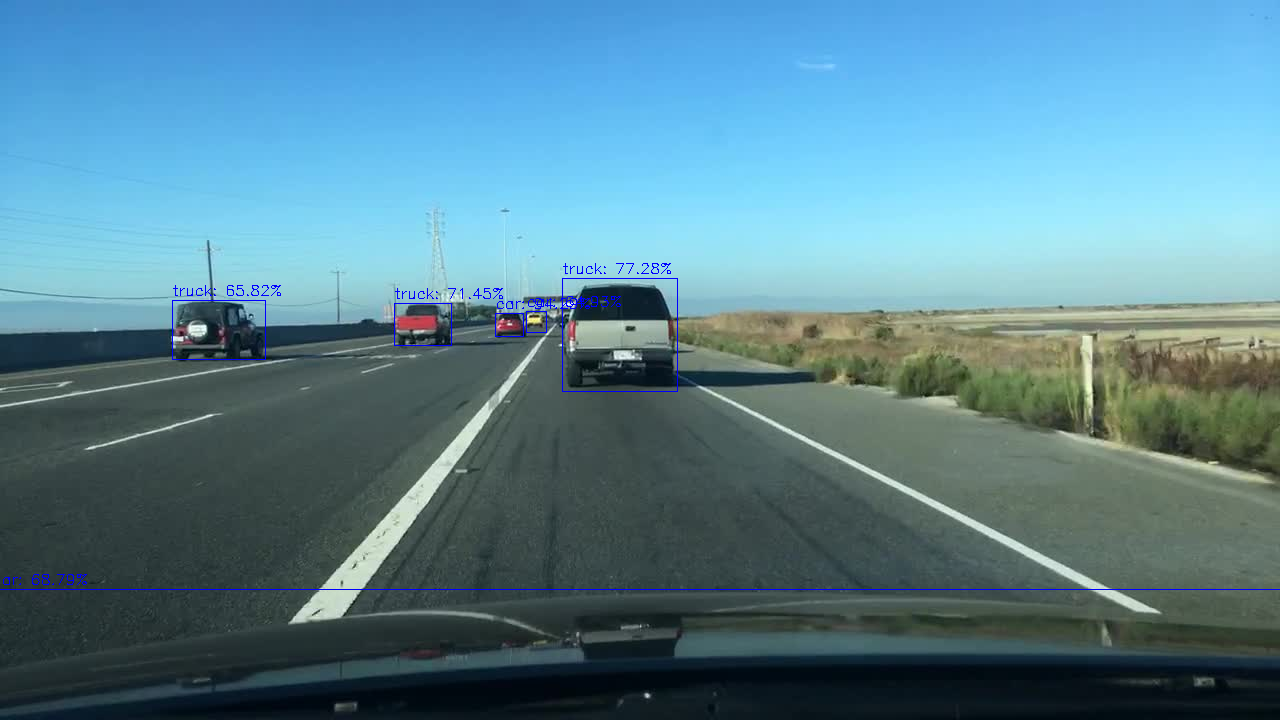

In [16]:
from google.colab.patches import cv2_imshow
cv2_imshow(img_to_detect)